# [IAPR][iapr]: Lab 3 ‒  Classification


**Group ID:** xx

**Author 1 (sciper):** Student Name 1 (xxxxx)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 23.04.2021  
**Due date:** 07.05.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

## Extract relevant data
We first need to extract the `lab-03-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In this part, we will study classification based on the data available in the Matlab file `classification.mat` that you will under `lab-03-data/part1`.
There are 3 data sets in this file, each one being a training set for a given class.
They are contained in variables `a`, `b` and `c`.

**Note**: we can load Matlab files using the [scipy.io] module.

[scipy.io]: https://docs.scipy.org/doc/scipy/reference/io.html

In [3]:
import scipy.io

data_part1_path = os.path.join(data_base_path, data_folder, 'part1', 'classification.mat')
matfile = scipy.io.loadmat(data_part1_path)
a = matfile['a']
b = matfile['b']
c = matfile['c']

print(a.shape, b.shape, c.shape)

(200, 2) (200, 2) (200, 2)


### 1.1 Bayes method (5 pts)
Using the Bayes method, give the expression of the separation curves between those three classes.
Do reasonable hypotheses about the distributions of those classes and estimate the corresponding parameters based on the given training sets.
Draw those curves on a plot, together with the training data. Note that you do not need to solve the analytical expression. You can simply evaluate the function for each point on the plane to end up with a segmentation map.
For simplicity reasons, round the estimated parameters to the closest integer value.

In [175]:
import matplotlib.pyplot as plt
import statistics as stat
import numpy as np
from sympy import MatrixSymbol, Matrix
from numpy.linalg import inv
import math
from sympy import plot_implicit, symbols, Eq, And
import matplotlib.image as mpimg
from IPython.display import clear_output

### Data visualization and statistical parameters 

We first scatter the datapoints and see how the 3 classes may be separated. The C class seems to have a much more different covariance than A and B it may need to hyperparameters tuning to classify properly.
We then compute the mean and covariances for each dataset

Text(0, 0.5, 'feature 1')

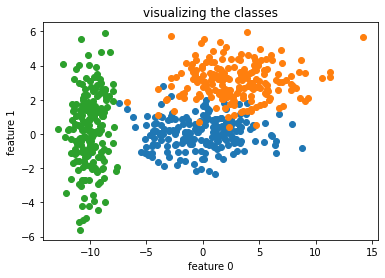

In [203]:

fig, ax = plt.subplots()
# scatter the data
ax.scatter(a[:,0] , a[:,1])
ax.scatter(b[:,0], b[:,1])
ax.scatter(c[:,0],c[:,1])
# set a title and labels
ax.set_title('visualizing the classes')
ax.set_xlabel('feature 0')
ax.set_ylabel('feature 1')

In [ ]:
#Computing means
mean_a=[0,0]
mean_a[0]=stat.mean(a[:,0])
mean_a[1]=stat.mean(a[:,1])

mean_b=[0,0]
mean_b[0]=stat.mean(b[:,0])
mean_b[1]=stat.mean(b[:,1])

mean_c=[0,0]
mean_c[0]=stat.mean(c[:,0])
mean_c[1]=stat.mean(c[:,1])


#Computing covariances
cov_a=np.cov(a,rowvar=False)
cov_b=np.cov(b,rowvar=False)
cov_c=np.cov(c,rowvar=False)

#computing probabilites

p_wa=a.shape[0]/(a.shape[0]+b.shape[0]+c.shape[0])
p_wb=b.shape[0]/(a.shape[0]+b.shape[0]+c.shape[0])
p_wc=c.shape[0]/(a.shape[0]+b.shape[0]+c.shape[0])

print("Class a :\n", "Mean ", mean_a ,"\n" ,"Cov:",list(cov_a),"\n", "proba", p_wa)
print("Class b :\n", "Mean ", mean_b ,"\n" ,"Cov:",list(cov_b),"\n", "proba", p_wb)
print("Class c :\n", "Mean ", mean_c ,"\n" ,"Cov:",list(cov_c),"\n", "proba", p_wc)

### Numerical accuracy of classifier 
Here we define the hyperplane equation and compute the numerical accuracy of our classifier.
As predicted, class C required some hyperparameters tunning as we set the constant to -3 instead of the default 0. We get results above 95% this is really good!

In [159]:
def discr(mean, cov, X, p_wi, C):
    return (-1/2)* np.transpose(X) @ inv(cov) @ X+(1/2) * np.transpose(X) @ inv(cov)  @ mean -(1/2) * np.transpose(mean)@ inv(cov) @ mean + (1/2) * np.transpose(mean)@inv(cov)@X  + math.log(p_wi)+ C
#constants magic numbers for simplicity 
CLASS_A=0
CLASS_B=1
CLASS_C=2

def accuracy(X,TEST_CLASS):
    score=0
    for x in X:
        if (np.argmax([discr(mean_a, cov_a ,x , p_wa, 0),discr(mean_b, cov_b ,x , p_wb, 0),discr(mean_c, cov_c ,x , p_wc,-3)]) == TEST_CLASS):
            score+=1
    return score/X.shape[0]

In [187]:
print ("Accuracy A:",accuracy(a,CLASS_A),"\nAccuracy B:", accuracy(b,CLASS_B) ,"\nAccuracy C:",accuracy(c,CLASS_C))

Accuracy A: 0.945 
Accuracy B: 0.955 
Accuracy C: 0.96


### Visualisazion of classifier 
We visualize the three regions that were separated by our classifier 
Here we used an implicit function plotting library  called scympy.
The regions are isolated by making sure that each classis bounded by the combination of the two hyperplanes separating them from the other two classes respectively.

In [188]:
def quadratic(x,y,cov):
    inverse_cov=inv(cov)
    a=inverse_cov[0,0]
    b=inverse_cov[0,1]
    c=inverse_cov[1,0]
    d=inverse_cov[1,1]
    return 1/2*(x*(a*x+c*y) + y*(b*x + d*y))

def constant (mean, cov, p_wi, C):
    return -(1/2) * np.transpose(mean)@ inv(cov) @ mean   + math.log(p_wi)+ C
 
def linear(mean, cov, x, y):

    inverse_cov=inv(cov)
    a=inverse_cov[0,0]
    b=inverse_cov[0,1]
    c=inverse_cov[1,0]
    d=inverse_cov[1,1]
    
    return (1/2)*(mean[0]*(a*x+c*y) 
                  + mean[1]*(b*x + d*y) +x*(a*mean[0]+ c*mean[1])+y*( b*mean[0]+ d*mean[1]))


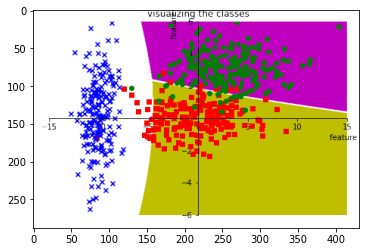

In [189]:
x1, x2 = symbols('x y')

expr_c= quadratic(x1,x2,cov_c)+linear(mean_c,cov_c,x1,x2)+constant(mean_c, cov_c  , p_wc, -5 )
expr_b=quadratic(x1,x2,cov_b)+linear(mean_b, cov_b, x1,x2)+constant(mean_b,cov_b,p_wb,0)
expr_a=quadratic(x1,x2,cov_a)+ linear( mean_a,cov_a, x1,x2)+ constant(mean_a,cov_a,p_wa,0)

p1 = plot_implicit(And((expr_a>expr_b),(expr_a>expr_c)), (x1,-15,15), (x2,-6,6) ,show=False,line_color='y')

p2=plot_implicit(And((expr_b>expr_a),(expr_b>expr_c)), (x1,-15,15), (x2,-6,6),show=False, line_color='m')               

p3=plot_implicit(And((expr_c>expr_a),(expr_c>expr_b)), (x1,-15,15), (x2,-6,6),show=False, line_color='w')
                   
p1.extend(p2)     
p1.extend(p3)          
p1.show()
clear_output()

fg, ax = p1._backend.fig, p1._backend.ax[0]  # get matplotib's figure and axes

# Use matplotlib to change appearance:
ax.scatter(a[:,0] , a[:,1],zorder=2,marker='s',color='r')
ax.scatter(b[:,0], b[:,1],zorder=2, color='g')
ax.scatter(c[:,0],c[:,1], zorder=2,marker='x',color='b')


# set a title and labels
ax.set_title('visualizing the classes')
ax.set_xlabel('feature 0')
ax.set_ylabel('feature 1')

#plt.plot(p1)
plt.show()

fg.savefig('demo.png')#, bbox_inches='tight')
img = mpimg.imread('demo.png')
plt.imshow(img)
plt.show()

### 1.2 Mahalanobis distance (5 pts)
For classes `a` and `b`, give the expression of the Mahalanobis distance used to classify a point in class `a` or `b`, and verify the obtained classification, in comparison with the "complete" Bayes classification, for a few points of the plane.

In [164]:
# Add your implementation and discussion

def mahal_dist(x,y, cov):
    inverse_cov=inv(cov)
    a=inverse_cov[0,0]
    b=inverse_cov[0,1]
    c=inverse_cov[1,0]
    d=inverse_cov[1,1]
    return (x*(a*x+c*y) + y*(b*x + d*y))

def normal_vector(mean_i,mean_j,cov):
    return inv(cov)@np.subtract(mean_i,mean_j)
    
def x0(mu_i,mu_j,cov,p_i,p_j,x,y):
    return (1/2)*(1/2)*np.add(mu_i,mu_j)-math.log(p_i/p_j)*np.add(mu_i,mu_j)/mahal_dist(x,y,cov)

#constants magic numbers for simplicity 
CLASS_A=0
CLASS_B=1
def acc_mahal(X,TEST_CLASS,mean_a,mean_b,cov):
    score=0
    for x in X:
        if (np.argmin([(x-mean_a)@inv(cov)@(x-mean_a),(x-mean_b)@inv(cov)@(x-mean_b)]) == TEST_CLASS):
            score+=1
    return score/X.shape[0]


### Numerical accuracy of mahalanobis classifier 
Here we define the hyperplane equation and compute the numerical accuracy of our classifier.
Interestingly both class a and b have similar covariances so it could make sense to use a mahalonobis classifier. This yields to results very similar to the previous classifier! We clearly see that using either covariances A or B is the same thing as they are really close! However, for the class C the covariance was too different and using mahalanobis for C would not be a good idea.

In [197]:
print("Using covariance A:\n Class A:",acc_mahal(a,CLASS_A,mean_a,mean_b,cov_a),"\n Class B",acc_mahal(b,CLASS_B,mean_a,mean_b,cov_a))
print("Using covariance B: \n Class A",acc_mahal(a,CLASS_A,mean_a,mean_b,cov_b),"\n Class B",acc_mahal(b,CLASS_B,mean_a,mean_b,cov_b))
      

Using covariance A:
 Class A: 0.955 
 Class B 0.94
Using covariance B: 
 Class A 0.96 
 Class B 0.95


### Visualisazion of classifier 
We visualize the two regions that were separated by our classifier using the scympy api using covariance of class A and then covariance of class B.

Using covariance of class A

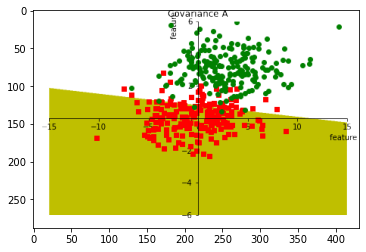

In [199]:
x1, x2 = symbols('x y')
expr= normal_vector(mean_a,mean_b,cov_a)@([x1,x2]-x0(mean_a,mean_b,cov_a,p_wa,p_wb,x1,x2))
p1 = plot_implicit(expr>0, (x1,-15,15), (x2,-6,6) ,show=False,line_color='y')
p1.show()
clear_output()

fg, ax = p1._backend.fig, p1._backend.ax[0]  # get matplotib's figure and axes

# Use matplotlib to change appearance:
ax.scatter(a[:,0] , a[:,1],zorder=2,marker='s',color='r')
ax.scatter(b[:,0], b[:,1],zorder=2, color='g')

# set a title and labels
ax.set_title('Covariance A')
plt.show()
fg.savefig('demo1.png')#, bbox_inches='tight')
img = mpimg.imread('demo1.png')
plt.imshow(img)
plt.show()


Using covariance of class B


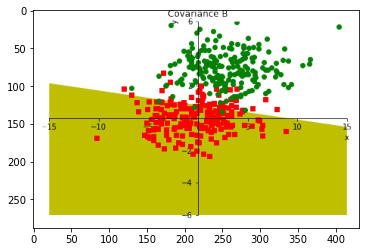

In [202]:
x1, x2 = symbols('x y')
expr= normal_vector(mean_a,mean_b,cov_b)@([x1,x2]-x0(mean_a,mean_b,cov_b,p_wa,p_wb,x1,x2))
p1 = plot_implicit(expr>0, (x1,-15,15), (x2,-6,6) ,show=False,line_color='y')
p1.show()
clear_output()

fg, ax = p1._backend.fig, p1._backend.ax[0]  # get matplotib's figure and axes

# Use matplotlib to change appearance:
ax.scatter(a[:,0] , a[:,1],zorder=2,marker='s',color='r')
ax.scatter(b[:,0], b[:,1],zorder=2, color='g')

# set a title and labels
ax.set_title('Covariance B')
#plt.plot(p1)
plt.show()

fg.savefig('demo1.png')#, bbox_inches='tight')
img = mpimg.imread('demo1.png')
plt.imshow(img)
plt.show()



---

## Part 2
In this part, we aim to classify digits using the complete version of MNIST digits dataset.
The dataset consists of 60'000 training images and 10'000 test images of handwritten digits.
Each image has size 28x28, and has assigned a label from zero to nine, denoting the digits value.
Given this data, your task is to construct a Multilayer Perceptron (MLP) for supervised training and classification and evaluate it on the test images.

Download the MNIST dataset (all 4 files) from http://yann.lecun.com/exdb/mnist/ under `lab-03-data/part2`.
You can then use the script provided below to extract and load training and testing images in Python. 

**! Warning**: When the lab was created the official MNIST repo was down, if it is still the case please use https://github.com/mkolod/MNIST.

### 2.1 Dataset loading
Here we first declare the methods `extract_data` and `extract_labels` so that we can reuse them later in the code.
Then we extract both the data and corresponding labels, and plot randomly some images and corresponding labels of the training set.

In [ ]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [ ]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

In [ ]:
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

### 2.2 MLP (10 pts)

To create an MLP you are free to choose any library.
In case you don't have any preferences, we encourage you to use the [scikit-learn] package; it is a simple, efficient and free tool for data analysis and machine learning.
In this [link][sklearn-example], you can find a basic example to see how to create and train an MLP using [scikit-learn].
Your network should have the following properties:
* Input `x`: 784-dimensional (i.e. 784 visible units representing the flattened 28x28 pixel images).
* 100 hidden units `h`.
* 10 output units `y`, i.e. the labels, with a value close to one in the i-th class representing a high probability of the input representing the digit `i`.

If you need additional examples you can borrow some code from image classification tutorials.
However, we recommend that you construct a minimal version of the network on your own to gain better insights.

[scikit-learn]: http://scikit-learn.org/stable/index.html
[sklearn-example]: http://scikit-learn.org/stable/modules/neural_networks_supervised.html

In [ ]:
# Add your implementation and discussion
import torch


In [ ]:
HIDDEN_UNITS=100
INPUT_SIZE=784 #flatten the 28x28 pixels













In [ ]:
nn.sequentia